In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix 
from sklearn.svm import SVC 
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [36]:
df = pd.read_csv("./data/ASML_v1.csv")
print("df shape:",df.shape)
df = df.drop(["Unnamed: 0","Open","High","Low"],axis=1)

#Extract date as new features
df["Date"] = pd.to_datetime(df["Date"],format="%Y-%m-%d")
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day
df = df.set_index("Date")

# create target label: direction
dire_lst = df.Close-df.Close.shift(1)
out = map(lambda v: 1 if v > 0 else -1, dire_lst)
df["direction"] = list(out)
df = df.iloc[10:,:]
#df = df.drop(["Close"],axis=1) #TODO:TEST ME
df = df.dropna()
df 

df shape: (2769, 20)


,Close,Adj Close,Volume,obv,ma6,ma10,rsi6,rsi10,macd,dif,atr10,atr20,bias6,bias10,tapi,year,month,day,direction
Date,,,,,,,,,,,,,,,,,,,
2011-01-20,38.570000,27.553640,7719700,269900,38.576667,37.674000,53.837171,54.278405,0.476437,0.118528,1.366569,1.101779,-0.001111,0.089600,200147.783251,2011,1,20,1
2011-01-21,38.950001,27.825106,2598400,2868300,38.821667,37.937000,56.410881,56.107158,0.514093,0.124948,1.308912,1.086190,0.021389,0.101300,66711.166452,2011,1,21,1
2011-01-24,39.700001,28.360889,4145300,7013600,39.223334,38.276000,61.495272,59.646698,0.597567,0.166737,1.316021,1.100880,0.079445,0.142400,104415.614498,2011,1,24,1
2011-01-25,41.040001,29.318165,7593700,14607300,39.258333,38.790000,69.198283,65.215257,0.763051,0.265777,1.339419,1.123336,0.296945,0.225000,185031.671905,2011,1,25,1
2011-01-26,41.860001,29.903955,5097300,19704600,39.551667,39.301000,73.143621,68.199061,0.949421,0.361718,1.331477,1.130169,0.384722,0.255900,121770.183426,2011,1,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24,802.390015,802.390015,1246700,124901800,838.561666,843.365997,28.343878,38.557671,7.407704,-5.876408,22.468035,21.264977,-6.028608,-4.097598,1553.733193,2021,11,24,-1
2021-11-26,782.020020,782.020020,786300,124115500,825.654999,838.228998,22.086933,33.081897,2.743630,-8.432385,22.859232,21.520728,-7.272496,-5.620898,1005.472980,2021,11,26,-1
2021-11-29,815.010010,815.010010,1410700,125526200,814.970001,834.566998,45.477899,46.702350,1.689855,-7.588928,23.944304,22.130190,0.006668,-1.955699,1730.898986,2021,11,29,1


## K fold preparation

In [37]:
full_features = [col for col in df.columns if col!='year' and col!='month' and col!='day' and col!='Close' and col!='Adj Close' and col!= 'Volume' ]
fer_features =  ['Adj Close','Volume',"rsi6","macd","direction"]
fer_features_adj =  ["rsi6","macd","direction"]
ran_features = ["rsi10","rsi6","direction"]
date_features = ['year',"month","day","direction"]
add_date_falg = False
fea_lst = [full_features,fer_features,fer_features_adj,ran_features,date_features]
met_lst = ["fully expanded features","PCA + clustering","PCA + clustering adj", "K best selection", "Only dates"]
acc_lst = []
scaler = StandardScaler()
for index,features in enumerate(fea_lst):
    X = df[features].drop(["direction"],axis=1).to_numpy()
    scaler.fit(X)
    X = scaler.transform(X)
    if add_date_falg == True:
        X = df[features+date_features].drop(["direction"],axis=1).to_numpy()
    y = df["direction"].to_numpy()
    kf = KFold(n_splits=2, shuffle=True, random_state=520)

    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # Full feature
    model = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=50, kernel="rbf",
    max_iter=-1, probability=False, random_state=None, 
    shrinking=True, tol=0.001, verbose=False
    ) 
    model.fit(X_train, y_train) 
    pred = model.predict(X_test) 
    acc_full = model.score(X_test, y_test)
    print("method:",met_lst[index])
    print('add_date_falg',add_date_falg)
    acc_lst.append(np.round(acc_full*100,2))
    print("%0.4f" % acc_full) 
    print("%s\n" % confusion_matrix(pred, y_test)) 
    # TODO: Add recall in percentage

method: fully expanded features
add_date_falg False
0.5461
[[ 82  63]
 [558 665]]

method: PCA + clustering
add_date_falg False
0.5643
[[236 192]
 [404 536]]

method: PCA + clustering adj
add_date_falg False
0.6520
[[352 188]
 [288 540]]

method: K best selection
add_date_falg False
0.6725
[[389 197]
 [251 531]]

method: Only dates
add_date_falg False
0.4912
[[206 262]
 [434 466]]



add_date_falg False


Text(0.5, 1.0, 'Performance of SVM models')

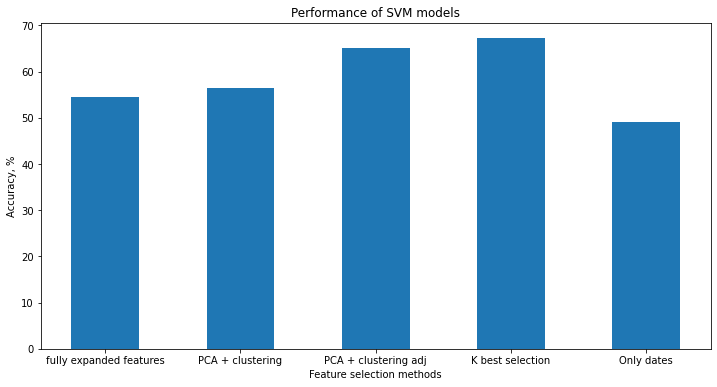

In [38]:
# Plots
fig, ax = plt.subplots(figsize=[12,6])    
plt.bar(met_lst,acc_lst,width = 0.5)
print("add_date_falg",add_date_falg)
plt.xlabel("Feature selection methods")
plt.ylabel("Accuracy, %")
plt.title("Performance of SVM models")



In [39]:
y

array([ 1,  1,  1, ...,  1, -1,  1], dtype=int64)

In [40]:
## Fernanda feature selection
df = pd.read_csv("./data/ASML_v1.csv")
print("df shape:",df.shape)
df = df.drop(["Unnamed: 0","Open","High","Low"],axis=1)

#Extract date as new features
df["Date"] = pd.to_datetime(df["Date"],format="%Y-%m-%d")
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day
df = df.set_index("Date")
df=df.dropna()
# create target label: direction
dire_lst = df.Close-df.Close.shift(1)
out = map(lambda v: 1 if v > 0 else -1, dire_lst)
df["direction"] = list(out)

df = df[["Adj Close","Volume","rsi6","macd","direction"]]

#K fold
X = df.drop(["direction"],axis=1).to_numpy()
y = df["direction"].to_numpy()
kf = KFold(n_splits=2, shuffle=True, random_state=520)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

model = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=50, kernel="rbf",
max_iter=-1, probability=False, random_state=None, 
shrinking=True, tol=0.001, verbose=False
) 
model.fit(X_train, y_train) 
pred = model.predict(X_test) 
acc_ran = model.score(X_test, y_test)
print("%0.4f" % acc_ran) 
print("%s\n" % confusion_matrix(pred, y_test)) 
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))

df shape: (2769, 20)
0.5314
[[  0   0]
 [641 727]]

Accuracy: 0.5314327485380117
Precision: 0.5314327485380117


In [41]:
# Ran feature selection
df = pd.read_csv("./data/ASML_v1.csv")
print("df shape:",df.shape)
df = df.drop(["Unnamed: 0","Open","High","Low"],axis=1)

#Extract date as new features
df["Date"] = pd.to_datetime(df["Date"],format="%Y-%m-%d")
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day
df = df.set_index("Date")

# create target label: direction
dire_lst = df.Close-df.Close.shift(1)
out = map(lambda v: 1 if v > 0 else -1, dire_lst)
df["direction"] = list(out)
df = df.iloc[10:,:]
#df = df.drop(["Close"],axis=1) #TODO:TEST ME
df = df.dropna()

df = df[["rsi10","rsi6","direction",]]
#df = df[["rsi10","rsi6","bias6","macd","bias10","direction",]]
#"rsi10","atr20","macd","ma6","ma10",'year','month','day',"atr20","ma6","ma10"

#K fold
X = df.drop(["direction"],axis=1).to_numpy()
y = df["direction"].to_numpy()
kf = KFold(n_splits=2, shuffle=True, random_state=520)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

model = SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=50, kernel="rbf",
max_iter=-1, probability=False, random_state=None, 
shrinking=True, tol=0.001, verbose=False
) 
model.fit(X_train, y_train) 
pred = model.predict(X_test) 
acc_ran = model.score(X_test, y_test)
print("%0.4f" % acc_ran) 
print("%s\n" % confusion_matrix(pred, y_test)) 
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))

df shape: (2769, 20)
0.5482
[[ 91  69]
 [549 659]]

Accuracy: 0.5482456140350878
Precision: 0.5455298013245033


In [42]:
# Performance comparision 
X_test

array([[54.27840546, 53.83717138],
       [56.10715826, 56.41088075],
       [65.21525694, 69.19828295],
       ...,
       [33.08189701, 22.0869327 ],
       [46.70235024, 45.47789882],
       [40.2225617 , 36.19041031]])